In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

#from Cuda import DeviceDataLoader

In [2]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
IMAGE_CHANNELS = 1
RANK = 200
H_DIM = 200 

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [4]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [5]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
#train_loader = DeviceDataLoader(train_loader, device)
#val_loader = DataLoader(val_ds, BATCH_SIZE)

In [6]:
#model = VAE_CP_L3_sparse_LU(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
model = VAE_CP_L3_sparse(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#model = DeviceDataLoader(model, device)


In [7]:
list_of_losses = []
list_of_epochs = []
for epoch in range(NUM_EPOCHS):
    for images, _ in train_loader: 
        images = images.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)   
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), images.to(device), mu.to(device), logvar.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    list_of_losses.append(loss)
    list_of_epochs.append(epoch + 1)
    print('loss', loss)
    print("Epoch : ", epoch + 1)

/home/ashish/Softwares/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss tensor(2400.7932, grad_fn=<AddBackward0>)
Epoch :  1
loss tensor(1483.7148, grad_fn=<AddBackward0>)
Epoch :  2
loss tensor(1259.2136, grad_fn=<AddBackward0>)
Epoch :  3
loss tensor(1163.0020, grad_fn=<AddBackward0>)
Epoch :  4
loss tensor(1260.0419, grad_fn=<AddBackward0>)
Epoch :  5


In [8]:
for images, _ in train_loader: 
    recon_images, mu, logvar = model(images.to(device))
    break

In [9]:
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

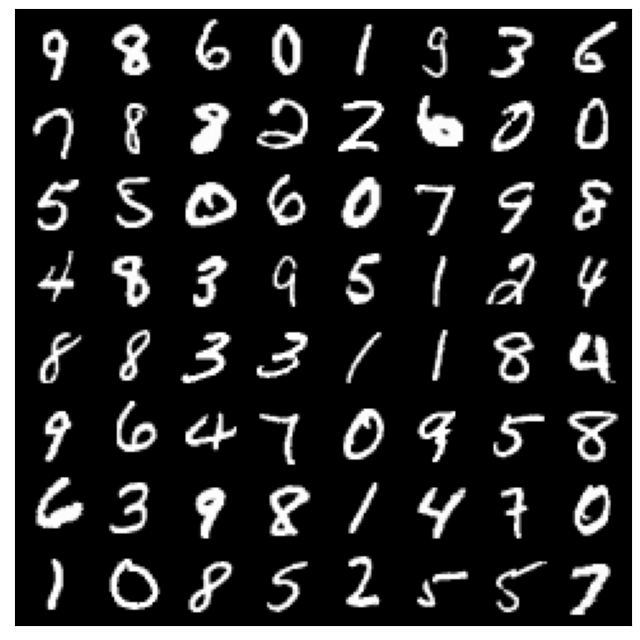

In [11]:
show_images(images)

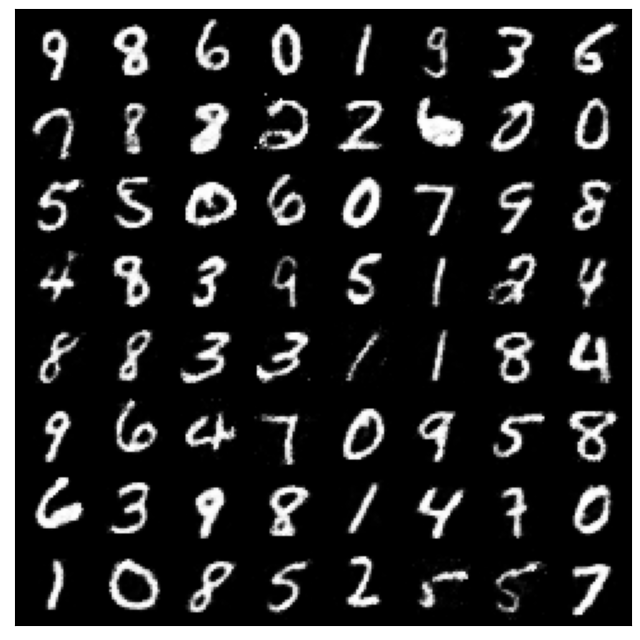

In [12]:
show_images(recon_images)

In [13]:
list_of_losses = [i.detach().numpy() for i in list_of_losses ]

In [14]:
my_dict = {
    "epochs": list_of_epochs, 
    "losses": list_of_losses
}

df = pd.DataFrame(my_dict)

In [15]:
df.style

,epochs,losses
0,1,2400.7932
1,2,1483.7148
2,3,1259.2136
3,4,1163.002
4,5,1260.0419


In [16]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

In [20]:
num_p = torch.sum(torch.tensor(num_param))

In [19]:
time = 60 + 15

In [23]:
dict = {
    "Number of parameters": num_p.detach().numpy(), 
    "Training Time (s)": time
}

df1 = pd.DataFrame([dict])

In [24]:
df1.style

,Number of parameters,Training Time (s)
0,535384,75
